In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -uq '/content/drive/MyDrive/Flickr8k_Dataset.zip' -d '/content'

In [3]:
!unzip -uq "/content/drive/MyDrive/Flickr8k_text.zip" -d "/content"

In [4]:
import os
os.environ['KAGGLE_USERNAME']="sahaisarthak"
os.environ['KAGGLE_KEY']="d098387b3f5ffbc08554acc0ce65122a"

In [5]:
!kaggle datasets download -d incorpes/glove6b200d

100% 259M/259M [00:13<00:00, 21.9MB/s]
100% 259M/259M [00:13<00:00, 19.9MB/s]


In [6]:
!unzip -uq "/content/glove6b200d.zip" -d "/content"

In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [55]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import glob
from PIL import Image
from time import time
from keras import Input, layers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.models import load_model
from keras.utils import load_img, img_to_array

In [8]:
token_path = "/content/Flickr8k.token.txt"
train_images_path = '/content/Flickr_8k.trainImages.txt'
test_images_path = '/content/Flickr_8k.testImages.txt'
images_path = '/content/Flicker8k_Dataset/'
glove_path = '/content'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [9]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [10]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

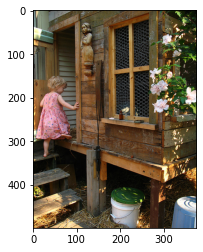

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [11]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

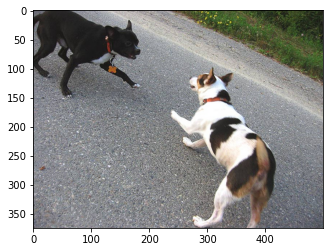

['a black dog and a spotted dog are fighting',
 'a black dog and a tricolored dog playing with each other on the road ',
 'a black dog and a white dog with brown spots are staring at each other in the street ',
 'two dogs of different breeds looking at each other on the road ',
 'two dogs on pavement moving toward each other ']

In [12]:
pic = '1001773457_577c3a7d70.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1001773457_577c3a7d70']

In [13]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [14]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [15]:
#loading 6000 training images
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [16]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [17]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)


In [18]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
for new_cap in all_train_captions[:5]:
  print(new_cap)

startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq
startseq a girl going into a wooden building endseq
startseq a little girl climbing into a wooden playhouse endseq
startseq a little girl climbing the stairs to her playhouse endseq
startseq a little girl in a pink dress going into a wooden cabin endseq


In [19]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [20]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [21]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [22]:
embeddings_index = {} 
f = open(os.path.join(glove_path,'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [23]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 5s 0us/step


In [25]:
model_new = Model(model.input, model.layers[-2].output)

In [40]:
def preprocess(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [41]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [42]:
#encoding our training and testing images
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step


In [43]:
#merging
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      332000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [44]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [45]:
#compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [46]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [47]:
epochs = 10
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
hist=model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/10
2000/2000 [==============================] - 215s 105ms/step - loss: 3.6853
Epoch 2/10
2000/2000 [==============================] - 210s 105ms/step - loss: 3.0299
Epoch 3/10
2000/2000 [==============================] - 206s 103ms/step - loss: 2.8305
Epoch 4/10
2000/2000 [==============================] - 205s 102ms/step - loss: 2.7112
Epoch 5/10
2000/2000 [==============================] - 206s 103ms/step - loss: 2.6265
Epoch 6/10
2000/2000 [==============================] - 206s 103ms/step - loss: 2.5595
Epoch 7/10
2000/2000 [==============================] - 208s 104ms/step - loss: 2.5082
Epoch 8/10
2000/2000 [==============================] - 205s 102ms/step - loss: 2.4660
Epoch 9/10
2000/2000 [==============================] - 204s 102ms/step - loss: 2.4299
Epoch 10/10
2000/2000 [==============================] - 202s 101ms/step - loss: 2.4003


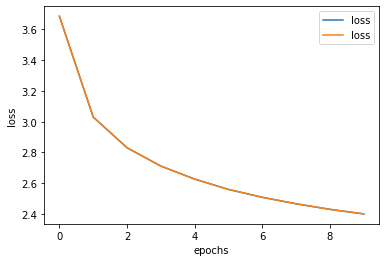

In [48]:
for label in ["loss","loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [49]:
model.save('/content/drive/MyDrive/Final_Image_Captioning.h5')

In [50]:
model=load_model('/content/drive/MyDrive/Final_Image_Captioning.h5')

In [51]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [59]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

1/1 [==============================] - 0s 24ms/step


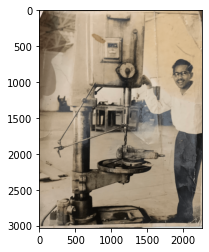

Greedy Search: a man in a black shirt sits on a bench near a building
Beam Search, K = 3: a man in a black shirt sits on a bench near a
Beam Search, K = 5: a bearded man in a white shirt is sitting on a wooden bench next to a bus
Beam Search, K = 7: a man in a black shirt sits on a wooden bench next to a bus
Beam Search, K = 10: a bearded man in a white shirt sits on a wooden bench next to a bus


In [60]:
from keras.preprocessing import image
path='/content/IMG_0721.png'
pic = encode(path)
image = pic.reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

1/1 [==============================] - 0s 25ms/step


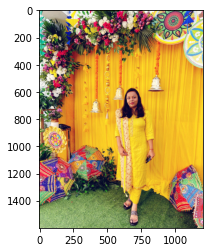

Greedy Search: a woman in a costume and a woman in a costume
Beam Search, K = 3: a young girl in a pink tutu is wearing a pink tutu
Beam Search, K = 5: a little girl in a white dress is standing in front of a tree
Beam Search, K = 7: a little girl in a white dress is standing in front of a tent
Beam Search, K = 10: a little girl in a white dress is surrounded by trees


In [61]:
from keras.preprocessing import image
path='/content/167a4685-12e3-43e1-af65-7ef74ae37a31.JPG'
pic = encode(path)
image = pic.reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

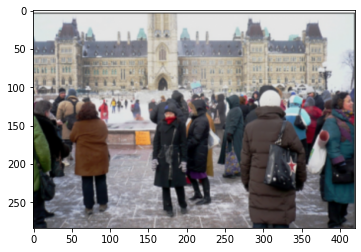

Greedy Search: a group of people are standing outside of a building
Beam Search, K = 3: a group of people are standing outside of a building
Beam Search, K = 5: a group of people are standing outside of a building
Beam Search, K = 7: a large group of people in front of a white building
Beam Search, K = 10: a large group of people in front of a white building


In [ ]:
from keras.preprocessing import image
path='/content/img3.png'
pic = encode(path)
image = pic.reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

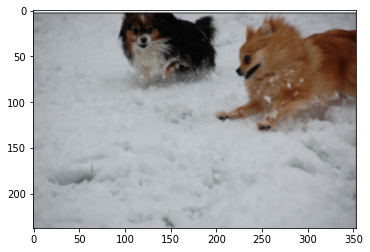

Greedy Search: a dog is running through the woods
Beam Search, K = 3: a black and white dog is running in the snow
Beam Search, K = 5: a black and white dog is running in the snow
Beam Search, K = 7: a black and white dog is running in the snow
Beam Search, K = 10: a black and white dog is running in the snow


In [ ]:
from keras.preprocessing import image
path='/content/img4.png'
pic = encode(path)
image = pic.reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

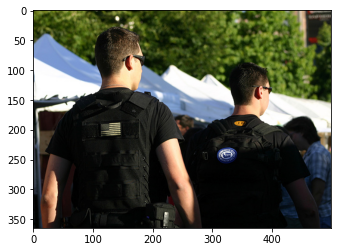

Greedy: a man in a black shirt is standing next to a woman in a black shirt
Beam Search, K = 3: a man in a black shirt is standing next to a woman in a hat
Beam Search, K = 5: a man in a white shirt is standing in front of a crowd
Beam Search, K = 7: a police officer officer officer posing for a picture
Beam Search, K = 10: a police officer officer officer posing for a picture


In [ ]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

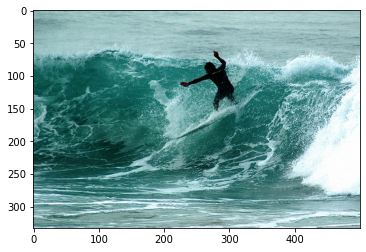

Greedy: a surfer rides a wave
Beam Search, K = 3: a surfer rides a wave
Beam Search, K = 5: someone is riding a surfboard on a breaking wave
Beam Search, K = 7: someone is riding a surfboard on a breaking wave
Beam Search, K = 10: this person is riding a surfboard on a breaking wave


In [ ]:
pic = list(encoding_test.keys())[2]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))